In [270]:
#!gcloud auth login


In [271]:
# from google.cloud import bigquery

# client = bigquery.Client(project="ga-portfolio-wallace")

# query = """
# SELECT *
# FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
# LIMIT 3000
# """

# df = client.query(query).to_dataframe()
# df.head(2)


| Campo                   | Tipo    | Nível  | Observação crítica           |
| ----------------------- | ------- | ------ | ---------------------------- |
| pageviews               | INTEGER | Sessão | Apenas hits do tipo PAGE     |
| hits                    | INTEGER | Sessão | Todos os tipos de interação  |
| bounces                 | INTEGER | Sessão | 1 = bounce                   |
| transactions            | INTEGER | Sessão | Ecommerce                    |
| totalTransactionRevenue | INTEGER | Sessão | Microunidades                |
| timeOnSite              | INTEGER | Sessão | Sessões com 1 hit ficam null |


In [272]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tools import *
import pandas as pd
import ast
from scipy.stats import mannwhitneyu

set_plot_style()

In [273]:
df = pd.read_csv('../data/raw/dados.csv')
df.head()

,visitorId,visitNumber,visitId,visitStartTime,date,totals,trafficSource,device,geoNetwork,customDimensions,hits,fullVisitorId,userId,clientId,channelGrouping,socialEngagementType
0,NaN,1,1501591568,1501591568,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Europe', 'subContinent': 'South...",[],"[{'hitNumber': 1, 'time': 0, 'hour': 5, 'minut...",3418334011779872055,NaN,NaN,Organic Search,Not Socially Engaged
1,NaN,2,1501589647,1501589647,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': '/analytics/web/', 'campaign'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Asia', 'subContinent': 'Souther...","[{'index': 4, 'value': 'APAC'}]","[{'hitNumber': 1, 'time': 0, 'hour': 5, 'minut...",2474397855041322408,NaN,NaN,Referral,Not Socially Engaged
2,NaN,1,1501616621,1501616621,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': '/analytics/web/', 'campaign'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Europe', 'subContinent': 'North...","[{'index': 4, 'value': 'EMEA'}]","[{'hitNumber': 1, 'time': 0, 'hour': 12, 'minu...",5870462820713110108,NaN,NaN,Referral,Not Socially Engaged
3,NaN,1,1501601200,1501601200,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': '/analytics/web/', 'campaign'...","{'browser': 'Firefox', 'browserVersion': 'not ...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 8, 'minut...",9397809171349480379,NaN,NaN,Referral,Not Socially Engaged
4,NaN,1,1501615525,1501615525,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': '/analytics/web/', 'campaign'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 12, 'minu...",6089902943184578335,NaN,NaN,Referral,Not Socially Engaged


In [274]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556 entries, 0 to 2555
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   visitorId             0 non-null      float64
 1   visitNumber           2556 non-null   int64  
 2   visitId               2556 non-null   int64  
 3   visitStartTime        2556 non-null   int64  
 4   date                  2556 non-null   int64  
 5   totals                2556 non-null   object 
 6   trafficSource         2556 non-null   object 
 7   device                2556 non-null   object 
 8   geoNetwork            2556 non-null   object 
 9   customDimensions      2556 non-null   object 
 10  hits                  2556 non-null   object 
 11  fullVisitorId         2556 non-null   uint64 
 12  userId                0 non-null      float64
 13  clientId              0 non-null      float64
 14  channelGrouping       2556 non-null   object 
 15  socialEngagementType 


Quais canais trazem mais sessões?

In [275]:
sessions_by_channel = df.groupby('channelGrouping').size().sort_values(ascending=True)
sessions_pct = sessions_by_channel / sessions_by_channel.sum() * 100

Organic Search    1104
Direct             315
Referral           263
Social             199
Paid Search         47
Affiliates          43
Display             29
Total             2000

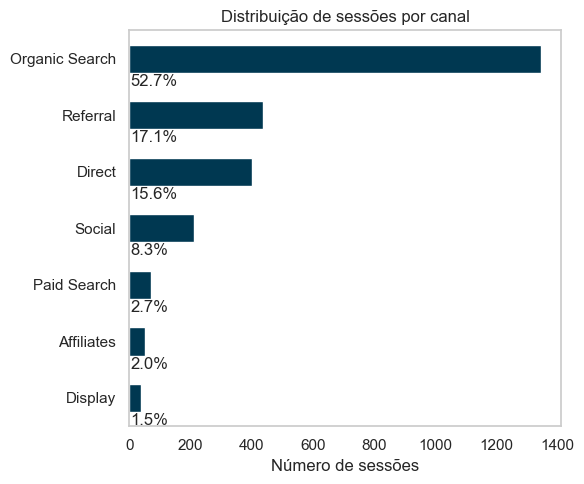

In [276]:
fig, ax = plt.subplots(figsize=(6, 5))

sessions_by_channel.plot(kind='barh', ax=ax)

ax.set_xlabel('Número de sessões')
ax.set_ylabel('')
ax.set_title('Distribuição de sessões por canal')
ax.grid(False)

for i, v in enumerate(sessions_pct):
    ax.text(3, i-0.4, f'{v:.1f}%', va='center')

plt.tight_layout()
plt.show()

In [277]:
df['trafficSource'] = df['trafficSource'].apply(ast.literal_eval)
df['source'] = df['trafficSource'].apply(lambda x: x.get('source'))
df['medium'] = df['trafficSource'].apply(lambda x: x.get('medium'))


In [278]:
df['source_medium'] = df['source'] + ' / ' + df['medium']
top_sm = df['source_medium'].value_counts().head(5).sort_values(ascending=True)
top_sm_pct = top_sm / top_sm.sum() * 100

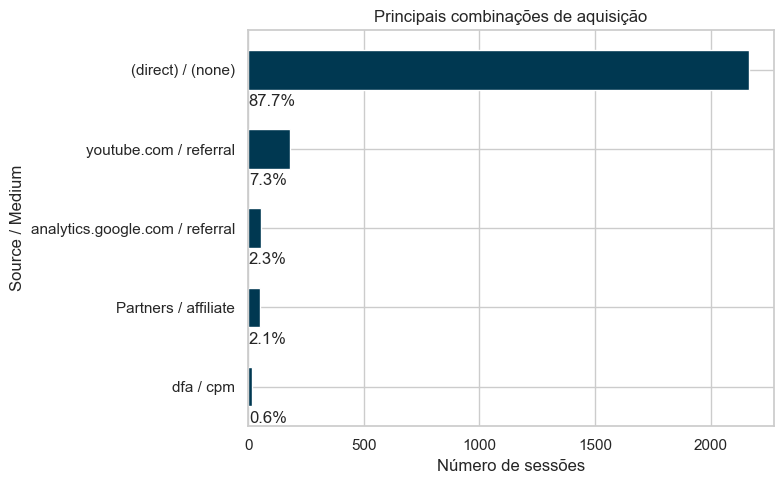

In [279]:
fig, ax = plt.subplots(figsize=(8, 5))
for i, v in enumerate(top_sm_pct):
    ax.text(3, i-0.4, f'{v:.1f}%', va='center')

top_sm.plot(kind='barh', figsize=(8, 5), ax = ax)
plt.xlabel('Número de sessões')
plt.ylabel('Source / Medium')
plt.title('Principais combinações de aquisição')
plt.tight_layout()
plt.show()

A análise dos canais de aquisição indica que o `Organic Search` é o principal responsável pela geração de sessões, concentrando **52.7%** do total. Esse resultado sugere um bom desempenho de `Search Engine Optimization`(SEO), o que contribui para a aquisição recorrente de usuários sem dependência direta de mídia paga.

Os canais `Direct`, `Referral` e `Social` apresentam participação relevante no volume de sessões. O tráfego `Direct` representa cerca de **15.6%**, porém esse canal pode englobar tanto acessos diretos **intencionais** (como digitação do endereço ou favoritos) quanto tráfego não corretamente rastreado, oriundo de aplicativos de mensagens, e-mails ou ausência de parâmetros de campanha que não são corretamente rotulados. A análise complementar `source / medium` reforça essas conclusões, evidenciando que a maior parte das sessões está classificada como (direct) / (none), o que limita afirmações categóricas sobre reconhecimento de marca. Entre as fontes identificáveis, destaca-se youtube.com / referral, sugerindo relevância da plataforma como canal de descoberta e geração de tráfego.

Os canais `Referral` e `Social`, que juntos somam **23,9%** das sessões, indicam uma presença consistente da marca em ambientes externos, como sites de terceiros e plataformas sociais, **sugerindo** potencial para estratégias de parcerias, distribuição de conteúdo e fortalecimento de presença digital.

Em contrapartida, os canais pagos (`Paid Search` e `Display`) apresentam baixa representatividade no conjunto de dados, o que pode indicar tanto subinvestimento nessas estratégias quanto baixo retorno sobre o investimento (ROI).



#--------------------------------#

Quais canais trazem sessões de melhor qualidade?


In [280]:
df.loc[180 ,'totals']

"{'visits': 1, 'hits': 1, 'pageviews': 1, 'timeOnSite': None, 'bounces': 1, 'transactions': None, 'transactionRevenue': None, 'newVisits': 1, 'screenviews': None, 'uniqueScreenviews': None, 'timeOnScreen': None, 'totalTransactionRevenue': None, 'sessionQualityDim': 1}"

In [281]:
df['totals'] = df['totals'].apply(ast.literal_eval)
df['pageviews'] = df['totals'].apply(lambda x: x.get('pageviews'))
df['bounces'] = df['totals'].apply(lambda x: x.get('bounces'))
df['timeOnSite'] = df['totals'].apply(lambda x: x.get('timeOnSite'))
df['transactions'] = df['totals'].apply(lambda x: x.get('transactions'))
df['totalTransactionRevenue'] = df['totals'].apply(lambda x: x.get('totalTransactionRevenue')) /1e6 


In [282]:
quality_by_channel = df.groupby('channelGrouping').agg({
    'pageviews': 'mean',
    'bounces': 'sum',
    'transactions': 'sum',
    'timeOnSite': 'mean',
    'totalTransactionRevenue': 'mean'
}).sort_values('pageviews', ascending=False)


In [283]:
quality_by_channel

,pageviews,bounces,transactions,timeOnSite,totalTransactionRevenue
channelGrouping,,,,,
Referral,7.419725,107.0,29.0,417.825688,203.288148
Paid Search,6.628571,22.0,1.0,401.229167,83.480000
Direct,4.625000,197.0,8.0,381.069652,318.613750
Display,4.435897,12.0,1.0,271.555556,40.290000
Organic Search,3.485884,715.0,6.0,271.006380,121.423333
Affiliates,2.615385,30.0,0.0,197.318182,NaN
Social,1.826291,155.0,0.0,202.431034,NaN


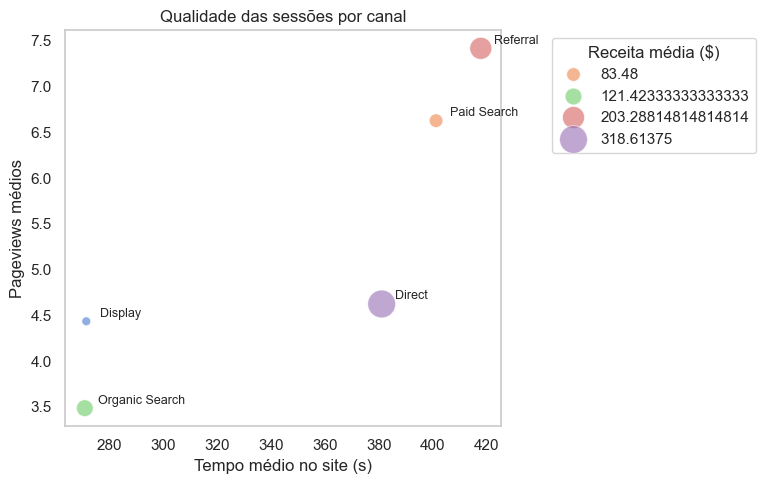

,pageviews,bounces,transactions,timeOnSite,totalTransactionRevenue
channelGrouping,,,,,
Referral,7.419725,107.0,29.0,417.825688,203.288148
Paid Search,6.628571,22.0,1.0,401.229167,83.480000
Direct,4.625000,197.0,8.0,381.069652,318.613750
Display,4.435897,12.0,1.0,271.555556,40.290000
Organic Search,3.485884,715.0,6.0,271.006380,121.423333


In [284]:
quality_plot = quality_by_channel.drop(['Social', 'Affiliates']
)
fig, ax = plt.subplots(figsize=(8, 5))

sns.scatterplot(
    x="timeOnSite",
    y="pageviews",
    hue="totalTransactionRevenue",
    size="totalTransactionRevenue",
    sizes=(40, 400),
    alpha=0.6,
    palette="muted",
    data=quality_plot,
    ax=ax
)


for channel, row in quality_plot.iterrows():
    ax.text(
        row['timeOnSite'] + 5,      
        row['pageviews'] + 0.05,    
        channel,
        fontsize=9
    )

ax.set_xlabel("Tempo médio no site (s)")
ax.set_ylabel("Pageviews médios")
ax.set_title("Qualidade das sessões por canal")
ax.grid(False)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], title="Receita média ($)", bbox_to_anchor=(1.1, 1), loc='upper left')


plt.tight_layout()
plt.show()
quality_plot

A análise da qualidade das sessões por canal revela diferenças tanto no comportamento médio dos usuários quanto no impacto absoluto em conversões e receita. As métricas de `pageviews` e `timeOnSite` foram analisadas como indicadores de **qualidade por canal**, enquanto `bounces` e `transactions` representam **volumes absolutos por canal**.

O canal `Referral` apresenta os maiores valores médios de *pageviews* (**7.42**) e tempo médio no site (**417.82s**), indicando sessões altamente engajadas. Além disso, esse canal registra o maior número absoluto de transações **29** entre os canais analisados, acompanhado de uma receita média relevante (**$203.29**). Esse conjunto de métricas caracteriza o `Referral` como um canal que combina **alto engajamento com forte capacidade de conversão**, o que indica que usuários chegam ao site por links externos que provavelmente já contextualizam o conteúdo, resultando em sessões mais engajadas.

O `Paid Search` também demonstra bom nível de engajamento médio, com *pageviews* (**6.63**) e tempo no site (**401.22s**) elevados. No entanto, o canal apresenta baixo volume absoluto de transações **1** e uma receita média inferior (**$83.48**), indicando que, apesar do interesse inicial dos usuários, há limitações na conversão efetiva, compatível com cenários em que a intenção de busca dos usuários é predominantemente informacional, a segmentação das campanhas não está alinhada a públicos alvo, ou a experiência da landing page não direciona de forma eficiente o usuário para a ação final.

O canal `Direct` se destaca como o principal gerador de **receita média por sessão** (**$318.61**), mesmo apresentando níveis intermediários de engajamento (*pageviews* **4.63** e tempo médio **381.07s**). Esse padrão sugere que usuários que acessam diretamente o site tendem a apresentar **maior intenção de compra**, resultando em conversões mais eficientes, ainda que um interação média intermediaria.

Já o **`Organic Search`**, responsável por mais da metade do volume total de sessões, apresenta menor engajamento médio `pageviews` **3.49** e tempo médio **271.01s** e o maior número absoluto de rejeições **715 bounces**. Ainda assim, o canal contribui com um volume consistente de transações (6) e receita média moderada **$121.42**, refletindo seu papel estratégico como canal de escala e descoberta ao longo do ciclo de decisão do usuário.

Por fim, o canal `Display` representa tráfego oriundo de anúncios gráficos e banners. Esse canal apresenta baixo nível de engajamento médio e impacto limitado em conversões diretas, combinando tempo médio reduzido (**271.55s**) com a menor receita média observada (≈ **$40.29**). Esses resultados é esperado e sugere um papel mais voltado à **exposição inicial da marca** do que à conversão imediata no período analisado.


De forma geral, os resultados indicam que **engajamento** é uma métrica **relevante** para avaliar a qualidade das sessões, estando associado a melhores resultados. No entanto, a análise conjunta das métricas médias e absolutas demonstra que a geração de receita **depende** da intenção do usuário associada a cada canal, evidenciando que alto engajamento, isoladamente, não garante necessariamente um maior faturamento.


Sessões com mais interações (pageviews ou hits) têm maior probabilidade de conversão.

In [285]:

df['conversion'] = (df['transactions'] > 0).astype(int)


grupo_0 = df[df['conversion'] == 0]['pageviews']
grupo_1 = df[df['conversion'] == 1]['pageviews']


n0 = len(grupo_0)
n1 = len(grupo_1)


median_0 = grupo_0.median()
median_1 = grupo_1.median()


U, p = mannwhitneyu(grupo_1, grupo_0, alternative='two-sided')

prob = U / (n0 * n1)

print("=== TAMANHO DOS GRUPOS ===")
print(f"Sem conversão (0): {n0}")
print(f"Com conversão (1): {n1}")

print("\n=== MEDIANA DE PAGEVIEWS ===")
print(f"Sem conversão: {median_0}")
print(f"Com conversão: {median_1}")

print("\n=== MANN-WHITNEY U ===")
print(f"Estatística U: {U}")
print(f"p-valor: {p:.3e}")

print("\n=== TAMANHO DO EFEITO ===")
print(f"P(pageviews_1 > pageviews_0): {prob:.4f}")



=== TAMANHO DOS GRUPOS ===
Sem conversão (0): 2513
Com conversão (1): 43

=== MEDIANA DE PAGEVIEWS ===
Sem conversão: 2.0
Com conversão: 23.0

=== MANN-WHITNEY U ===
Estatística U: 105161.0
p-valor: 7.396e-30

=== TAMANHO DO EFEITO ===
P(pageviews_1 > pageviews_0): 0.9732


A fim de investigar se sessões com maior número de interações convertem mais, foi criada uma variável binária de conversão (`conversion = 1` para sessões com pelo menos uma transação e `0` caso contrário). Observou-se forte desbalanceamento entre os grupos, com 2513 sessões sem conversão e apenas 43 com conversão.

A comparação das medianas de *pageviews* revelou diferença expressiva: sessões sem conversão apresentam mediana de **2 pageviews**, enquanto sessões com conversão apresentam mediana de **23 pageviews**. Esse contraste sugere que usuários que convertem interagem mais com o site.

Para avaliar se essa diferença é estatisticamente significativa, foi aplicado o teste não paramétrico de Mann–Whitney U, apropriado devido à assimetria e à presença de outliers na distribuição de *pageviews*. O resultado (U = 2898.0; p-valor = 7.396e-30) indica rejeição da hipótese nula de igualdade entre as distribuições, isto é, os dados mostram que maiores valores de *pageviews* estão associados a maior probabilidade de conversão.

O tamanho do efeito estimado indica que a probabilidade de uma sessão com conversão apresentar mais *pageviews* do que uma sessão sem conversão é aproximadamente **0.97**, caracterizando um efeito muito forte.

Em conjunto, os resultados demonstram uma associação estatisticamente robusta entre maior nível de interação e ocorrência de conversão. Embora não seja possível afirmar causalidade direta, os dados indicam que sessões com maior profundidade de navegação estão fortemente relacionadas à geração de transações no período analisado 


Por fim podemos análisar o volume de navegação e conversão por dia da semana, durante 1 mês.

In [ ]:
df_30dias = pd.read_csv('../data/raw\dados_30dias.csv')

In [ ]:
df_30dias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67393 entries, 0 to 67392
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            67393 non-null  int64  
 1   visitorId             0 non-null      float64
 2   visitNumber           67393 non-null  int64  
 3   visitId               67393 non-null  int64  
 4   visitStartTime        67393 non-null  int64  
 5   date                  67393 non-null  int64  
 6   totals                67393 non-null  object 
 7   trafficSource         67393 non-null  object 
 8   device                67393 non-null  object 
 9   geoNetwork            67393 non-null  object 
 10  customDimensions      67393 non-null  object 
 11  hits                  67393 non-null  object 
 12  fullVisitorId         67393 non-null  object 
 13  userId                0 non-null      float64
 14  clientId              0 non-null      float64
 15  channelGrouping    

In [ ]:
df_30dias['totals'] = df_30dias['totals'].apply(ast.literal_eval)
df_30dias['pageviews'] = df_30dias['totals'].apply(lambda x: x.get('pageviews'))
df_30dias['bounces'] = df_30dias['totals'].apply(lambda x: x.get('bounces'))
df_30dias['timeOnSite'] = df_30dias['totals'].apply(lambda x: x.get('timeOnSite'))
df_30dias['transactions'] = df_30dias['totals'].apply(lambda x: x.get('transactions'))
df_30dias['totalTransactionRevenue'] = df_30dias['totals'].apply(lambda x: x.get('totalTransactionRevenue')) /1e6 


In [ ]:
df_30dias['date_dt'] = pd.to_datetime(df_30dias['date'], format='%Y%m%d')
df_30dias['dayofweek'] = df_30dias['date_dt'].dt.dayofweek
df_30dias.head()

,Unnamed: 0,visitorId,visitNumber,visitId,visitStartTime,date,totals,trafficSource,device,geoNetwork,...,clientId,channelGrouping,socialEngagementType,pageviews,bounces,timeOnSite,transactions,totalTransactionRevenue,date_dt,dayofweek
0,0,NaN,1,1499062575,1499062575,20170702,"{'visits': 1, 'hits': 2, 'pageviews': 2, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Asia', 'subContinent': 'Eastern...",...,NaN,Organic Search,Not Socially Engaged,2.0,NaN,187.0,NaN,NaN,2017-07-02,6
1,1,NaN,1,1499033849,1499033849,20170702,"{'visits': 1, 'hits': 2, 'pageviews': 2, 'time...","{'referralPath': None, 'campaign': 'Data Share...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...",...,NaN,Affiliates,Not Socially Engaged,2.0,NaN,16.0,NaN,NaN,2017-07-02,6
2,2,NaN,3,1499065087,1499065087,20170702,"{'visits': 1, 'hits': 2, 'pageviews': 2, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Asia', 'subContinent': 'Souther...",...,NaN,Organic Search,Not Socially Engaged,2.0,NaN,37.0,NaN,NaN,2017-07-02,6
3,3,NaN,1,1498985212,1498985212,20170702,"{'visits': 1, 'hits': 2, 'pageviews': 2, 'time...","{'referralPath': '/analytics/web/', 'campaign'...","{'browser': 'Firefox', 'browserVersion': 'not ...","{'continent': 'Oceania', 'subContinent': 'Aust...",...,NaN,Referral,Not Socially Engaged,2.0,NaN,40.0,NaN,NaN,2017-07-02,6
4,4,NaN,1,1499030317,1499030317,20170702,"{'visits': 1, 'hits': 2, 'pageviews': 2, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Europe', 'subContinent': 'Weste...",...,NaN,Organic Search,Not Socially Engaged,2.0,NaN,22.0,NaN,NaN,2017-07-02,6


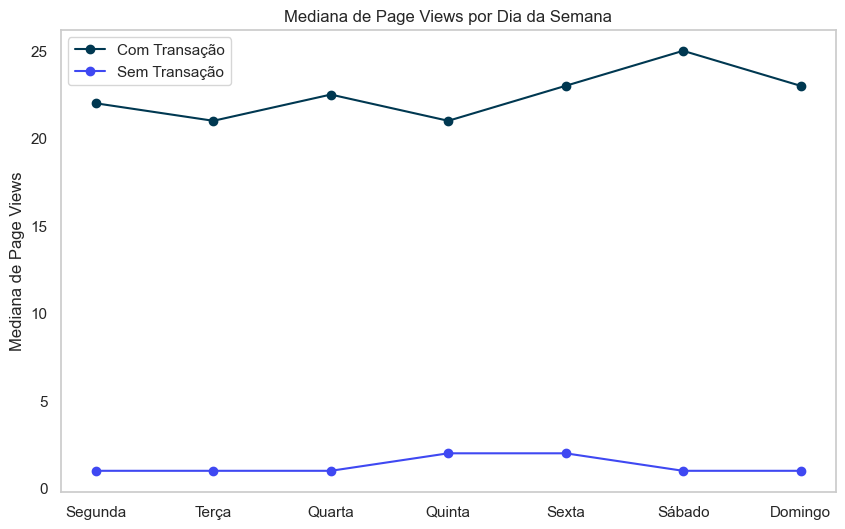

In [ ]:
df_30dias['transactions_zero'] = df_30dias['transactions'].fillna(0)

mediana_com_transacao = (
    df_30dias[df_30dias['transactions'] > 0]
    .groupby('dayofweek')['pageviews']
    .median()
)

mediana_sem_transacao = (
    df_30dias[df_30dias['transactions_zero'] == 0]
    .groupby('dayofweek')['pageviews']
    .median()
)

dias_semana = ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado', 'Domingo']
plt.figure(figsize=(10, 6))

mediana_com_transacao.plot(label='Com Transação', marker='o')
mediana_sem_transacao.plot(label='Sem Transação', marker='o')

plt.xticks(ticks=range(7), labels=dias_semana)
plt.title('Mediana de Page Views por Dia da Semana')
plt.xlabel('')
plt.ylabel('Mediana de Page Views')
plt.legend()
plt.grid(False)

A análise das medianas de pageviews por dia da semana evidencia uma associação clara entre volume de navegação e conversão. Sessões que resultaram em transação apresentam medianas entre 21 e 25 páginas visualizadas, enquanto sessões sem transação permanecem entre 1 e 2 páginas. Essa diferença é consistente ao longo de todos os dias da semana, indicando que o número de páginas visualizadas é um forte indicador de engajamento e está diretamente relacionado à probabilidade de conversão.